# Classifying Data with Logistic Regression in Python

## Project Objective
The purpose of this project is to predict if a new startup business will succeed. The predictors are xxxx and xxx, and the response is Succeed or Fail.

### Data Source
Business Start up dataset source information

URL: https://www.kaggle.com/datasets/ankurzing/success-of-startup

The dataset contains xxxx records and xxxxx fields

## Importing the Python Packages

import the required Python packages.

In [1]:
import pandas as pd # used to "tidy" up and manipulate our data
import numpy as np # used for matrix and numerical calculations; foundation of pandas
from scipy import stats # contains stats functions and is used to visualise probability distributions
from functools import reduce
from scipy.stats import norm 
from scipy.stats import sem # Standard error of mean
from scipy.stats import pearsonr # import pearsonr function to calculate  Pearson correlation coefficient
import matplotlib.pyplot as plt # used for visualisations
%matplotlib inline
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR') # error handling
import seaborn as sns # a more user-friendly library used for visualisations
sns.set_theme(rc={'figure.figsize':(10,6)})
import statistics
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# import model and matrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score

## 1. Collect the Data
Import the data into a dataframe called `df`.

In [2]:
df = pd.read_csv("C:/Users/ke337467/OneDrive - Oxfordshire County Council/Data Scientist Apprenticeship/Module Portfolio - Data Science Professional Practice/Business Start up logistic regression/big_startup_secsees_dataset.csv")

Drop any fields that are not required or this analysis.
The following fields were dropped.  
'state_code','permalink','homepage_url','category_list','country_code','region','city','name'  

To verify that the import worked as expected, preview the data using the `head()` method.

In [3]:
df.head()

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,Media,10000000,operating,IND,16,Mumbai,Mumbai,1,NaN,2015-01-05,2015-01-05
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878,operating,NaN,NaN,NaN,NaN,1,NaN,2014-01-30,2014-01-30
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24


## 2. Tidy up the data set

#### 2.1. Remove any fields that are not required

In [4]:
df.drop(['state_code','permalink','homepage_url','country_code','region','city','name','category_list'], axis = 1, inplace = True)

#### 2.2.Data frame does not have ad ID field
Add an `ID` field to the dataframe

In [5]:
df = df.assign(ID=range(1, len(df) + 1))

#### 2.3.Verify the condition of the data frame
Verify the condition of the data by checking:
>* Missing values.  
>* Data types.  

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   funding_total_usd  66368 non-null  object
 1   status             66368 non-null  object
 2   funding_rounds     66368 non-null  int64 
 3   founded_at         51147 non-null  object
 4   first_funding_at   66344 non-null  object
 5   last_funding_at    66368 non-null  object
 6   ID                 66368 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 3.5+ MB


#### 2.4. Observations
>* There are missing values in the data frame  
>* Date types are incorrect and inconsistent  
>* Field names could be revised  

In [7]:
df.rename(columns = {'founded_at':'Date_founded', 'first_funding_at':'Date_first_funded', 'last_funding_at':'Date_last_funded', 'funding_total_usd':'Total_Funding'}, inplace = True)

<hr>
<div class="alert alert-block alert-info">
<b>Discussion:</b> Filling in the missing dates from imputing missing values in **Section 2.9** .</div>
<hr>

#### 2.5. Filling in the missing dates
The date the business was founded contains `15,221` missing values. This information can be imputed from the date first funded. 
  
If the company received funding it would be reasonable to assume that the business started 1 or 2 or 3 years before the first funding grant. 
  
However the challenge is to work out what is the average difference between the date a company was founded and the first grant. This value rounded to the nearest year could be used to impute the `15,221` missing founding date. However calculating the average date with too many missing values is also problematic. This problem was resolved by initially imputing the missing dates using the date first funded plus one year.
  
The date the business was first funded contains 24 missing values. Using the average value between date of founding and date off first funding grant this value can also be imputed based on the data frame average

Replace missing dates in `Date_founded` with dates from `Date_first_funded` **minus 3 years** see step 1.10.or discussion on how this 3 year was calculated

Replace missing dates in `Date_first_funded` with dates from `Date_last_funded` **minus 1 year** see step 1.10.or discussion on how this 1 year was calculated
  

<hr>
<div class="alert alert-block alert-info">
<b>Discussion:</b> End of discussion on missing dates.</div>
<hr>

#### 2.6. Identifying invalid dates in the date fields
When converting the date fields from Pandas objects to date type invalid dates were detected by Pandas. These erroneous dates needed to be identified, and the records removed from the data frame.


In [8]:
# Convert to datetime, invalid parsing will be set as NaT
df['dates_E'] = pd.to_datetime(df['Date_founded' ], errors='coerce')
# Find invalid dates
invalid_dates = df[df['dates_E'].isna()]
invalid_dates.head()

,Total_Funding,status,funding_rounds,Date_founded,Date_first_funded,Date_last_funded,ID,dates_E
0,10000000,operating,1,NaN,2015-01-05,2015-01-05,1,NaT
2,3406878,operating,1,NaN,2014-01-30,2014-01-30,3,NaT
5,41250,operating,1,NaN,2014-07-01,2014-07-01,6,NaT
10,-,operating,1,NaN,2013-04-21,2013-04-21,11,NaT
28,3000000,operating,2,NaN,2008-01-07,2010-08-13,29,NaT


#### 2.7. Invalid dates identified and dropped
The invalid dates can be identified and the records dropped from the data frame.


In [9]:
df = df.drop(index=[4776,22208,24841,47830,59382])

#### 2.8. Identifying invalid dates in the date field Date_first_funded

In [10]:
# Convert to datetime, invalid parsing will be set as NaT
df['dates_E'] = pd.to_datetime(df['Date_first_funded' ], errors='coerce')

# Find invalid dates
invalid_dates = df[df['dates_E'].isna()]
invalid_dates.head()

,Total_Funding,status,funding_rounds,Date_founded,Date_first_funded,Date_last_funded,ID,dates_E
2445,12500000,operating,3,2014-02-01,NaN,2015-11-17,2446,NaT
3334,1190000,operating,6,2012-01-01,NaN,2014-03-23,3335,NaT
7409,32936998,operating,5,2010-01-01,1532-06-26,2013-12-03,7410,NaT
8029,1408347,operating,5,2011-11-01,NaN,2014-07-01,8030,NaT
9843,1000000,operating,2,2014-05-12,NaN,2014-10-22,9844,NaT


#### 2.9. Invalid dates identified and dropped
The invalid dates can be identified and the records dropped from the data frame.

In [11]:
df = df.drop(index=[7409,37176])

In [12]:
calc_date_first_funded = pd.to_datetime(df['Date_last_funded']) - pd.DateOffset(years=1)
df['Date_first_funded'] = df['Date_first_funded'].fillna(calc_date_first_funded)
calc_date_founded = pd.to_datetime(df['Date_first_funded']) - pd.DateOffset(years=3)
df['Date_founded'] = df['Date_founded'].fillna(calc_date_founded)

#### 2.10. Compute average durations to impute missing dates in the data frame
>1. Create a variable date_columns and store the date fields to be converted.  
>2. Convert columns to datetime using .astype method.  
>3. Calculate the average duration in years (rounded up) between date the business was `founded to the date of the first funding grant`
>4. Calculate the average duration in years (rounded up) between date of the `first funding grant` to the date of the `last funding grant`
>5. In `step 1.5` the missing dates in `Date_founded` were imputed with date from `Date_first_funded`.
>6. In `step 1.5` the missing dates in `Date_first_funded` were imputed with date from `Date_last_funded`.
>7. Steps 5 and 6 are incorrect but with these initial dates it is possible to calculate the average duration between ` Date_first_funded ` and `Date_last_funded` and between `Date_first_funded` and `Date_last_funded`.
>8. These steps were implemented at this point to calculate the average duration between these respective dates.
>9. The **average duration** between `date of founding` and `first funding grant` was calculated to be **`3 years`** (see image below of the original calculations and code which have now been commented out as this calculation is no longer required.
>10. The **average duration** between date of `first funding grant` and date of `last funding grant` and was calculated to be **`1 year`** (see image below of the original calculations and code which have now been commented out as this calculation is no longer required.



<hr>
<div class="alert alert-block alert-info">
<b>Discussion:</b> explanation on how the average duration between the key dates was calculated from imputing missing values in **Section 2.9** .</div>
<hr>

# Calculate the average duration between the key dates
Section below was initially used to calculate the average duration between the key dates so that the missing values could be imputed backwards from the `Date_last_funded`

<hr>
<div class="alert alert-block alert-warning">
<b>**Note:**</b> These step below have been commented out as they are no longer required see the image or the actual values and active code
</div>
<hr>

In [13]:
# Step 1 above 
#date_columns = ['Date_founded', 'Date_first_funded', 'Date_last_funded']
# Step 2 above
#df[date_columns] = df[date_columns].astype('datetime64[ns]')

In [14]:
#Step 3 above
#df['diff_founded_to_first_fund'] = (df['Date_first_funded'] - df['Date_founded']) / np.timedelta64(1, 'Y')
#avg_diff_founded_to_first_fund = round(df['diff_founded_to_first_fund'].mean(),0)
#avg_diff_founded_to_first_fund


In [15]:
#Step 4 above
#df['diff_first_to_last_fund'] = (df['Date_last_funded'] - df['Date_first_funded']) / np.timedelta64(1, 'Y')
#avg_diff_first_to_last_fund = round(df['diff_first_to_last_fund'].mean(),0)
#avg_diff_first_to_last_fund


Below is the image when the calcualtion were ran before imputing the values for the missing dates in Step 1.5

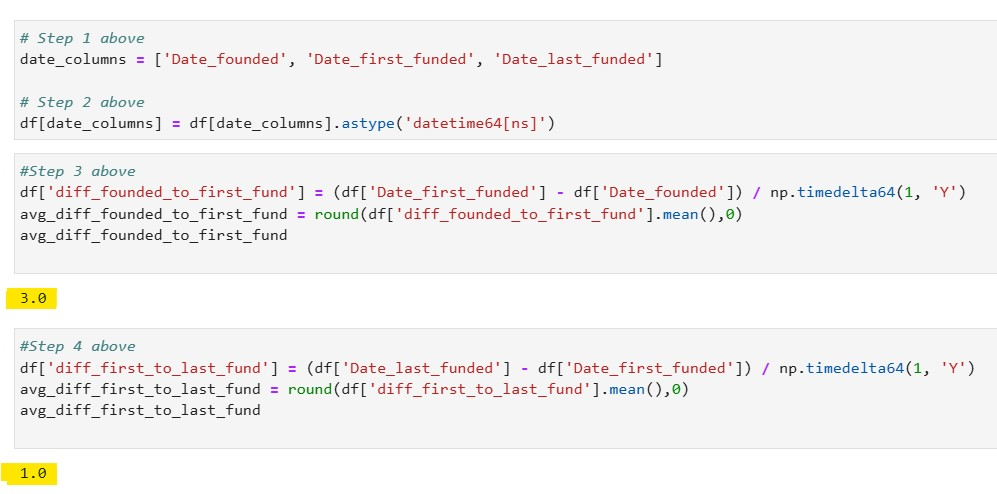

<hr>
<div class="alert alert-block alert-info">
<b>End of discussion:</b> above info/code is an image not code .</div>
<hr>

#### 2.11. Drop 'dates_E' field no longer required

In [16]:
df = df.drop(columns=['dates_E'])

#### 2.12.Assess how many missing values there are in the data frame

In [17]:
df.isnull().sum(axis=0)

Total_Funding        0
status               0
funding_rounds       0
Date_founded         0
Date_first_funded    0
Date_last_funded     0
ID                   0
dtype: int64

#### 2.13 Correct data types for modelling purposes


In [18]:
df['Date_founded'] = pd.to_datetime(df['Date_founded']).dt.normalize()
df['Date_first_funded'] = pd.to_datetime(df['Date_first_funded']).dt.normalize()
df['Date_last_funded'] = pd.to_datetime(df['Date_last_funded']).dt.normalize()
df['Total_Funding'] = pd.to_numeric(df['Total_Funding'],errors='coerce').fillna(0).astype(int)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66361 entries, 0 to 66367
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Total_Funding      66361 non-null  int32         
 1   status             66361 non-null  object        
 2   funding_rounds     66361 non-null  int64         
 3   Date_founded       66361 non-null  datetime64[ns]
 4   Date_first_funded  66361 non-null  datetime64[ns]
 5   Date_last_funded   66361 non-null  datetime64[ns]
 6   ID                 66361 non-null  int64         
dtypes: datetime64[ns](3), int32(1), int64(2), object(1)
memory usage: 3.8+ MB


In [20]:
df.head()

,Total_Funding,status,funding_rounds,Date_founded,Date_first_funded,Date_last_funded,ID
0,10000000,operating,1,2012-01-05,2015-01-05,2015-01-05,1
1,700000,operating,2,2014-09-04,2014-03-01,2014-10-14,2
2,3406878,operating,1,2011-01-30,2014-01-30,2014-01-30,3
3,2000000,operating,1,2007-01-01,2008-03-19,2008-03-19,4
4,0,operating,1,2010-01-01,2014-07-24,2014-07-24,5


#### 2.14. Review the distribution of startup status

In [21]:
# Count occurrences of each status value
status_counts = df['status'].value_counts()
status_counts

operating    53029
closed        6236
acquired      5549
ipo           1547
Name: status, dtype: int64

#### 2.15. Calculate the duration in months from founding to first funding grant
Duration is measured in months and rounded to the nearest month.


In [22]:
df['months_2_first_fund'] = round((df['Date_first_funded'] - df['Date_founded']) / np.timedelta64(1, 'M'),0).astype(int)
df.head(15)

,Total_Funding,status,funding_rounds,Date_founded,Date_first_funded,Date_last_funded,ID,months_2_first_fund
0,10000000,operating,1,2012-01-05,2015-01-05,2015-01-05,1,36
1,700000,operating,2,2014-09-04,2014-03-01,2014-10-14,2,-6
2,3406878,operating,1,2011-01-30,2014-01-30,2014-01-30,3,36
3,2000000,operating,1,2007-01-01,2008-03-19,2008-03-19,4,15
4,0,operating,1,2010-01-01,2014-07-24,2014-07-24,5,55
5,41250,operating,1,2011-07-01,2014-07-01,2014-07-01,6,36
6,762851,operating,2,1997-01-01,2009-09-11,2009-12-21,7,152
7,33600000,operating,4,2011-01-01,2013-01-03,2015-11-09,8,24
8,1150050,operating,3,2011-08-01,2011-07-20,2014-02-05,9,0
9,40000,operating,1,2012-01-01,2013-02-18,2013-02-18,10,14


<hr>
<div class="alert alert-block alert-info">
<b>Discussion:</b> explanation on how more data quality issues were identified and resolved .</div>
<hr>

# Data Quality and data cleaning challenges.
### Summary of the challanges
The dataset contains several complexities that need to be resolved
1. **Incorrect data types:** Apart from the `funding_rounds` fields all fields are Pandas objects
2. **Missing dates:** There are a significant number of missing values in the dataset. For the most part the missing values can be imputed from other fields (see discussion in `Section 2.10` and `Section 2.5` on how missing dates were resolved)
3. **Invalid dates:** The dataset contains several invalid dates (seven were found and their respective records removed from the dataset).
4. **Inconsistent dates:** The dataset was further enhanced by adding the duration field `months_2_first_fund` which calculated the duration in months between founding of the company ad their first funding grant. The problem encountered at this point in the data preparation was that based on the duration calculation it was then noted that there were 3,222 negative duration periods i.e. the date `Date_first_funded` was **before** the `Date_founded` which created a new problem that needed to be resolved.
5. Zero or Negative funding: 12,736 companies received a total funding amount of `0.00` and 21 companies received **negative funding** which is unlikely and these should be considered as error and were removed from the dataframe.

### Resolving the date errors
Resolving the inconsistent date errors (`Date_first_funded` **before** the `Date_founded`). The error was inconsistent and gross making I very difficult to save any of the fields that were affected by this error.
  
*3,222 records were the `Date_first_funded` was before the `Date_founded`
*Max error is 1,086 months
*Min error is 1 month
*Standard deviation of errors is 33 months (indicating a wide range of errors)
*IQR is 10 months 


Use the Interquartile Range (IQR) to remove the significant outliers from the dataset
Solution and code for this removing the error within the IQR

Source: https://saturncloud.io/blog/how-to-detect-and-exclude-outliers-in-a-pandas-dataframe/

### Resolving the Zero and Negative funding errors
The records that received zero funding could be considered as being startup companies that succeeded or failed without `startup funding` there are 12,736 companies out of `66,057` representing 19.3% of the data set. It would be interesting to create a predictor variable for companies that were funded compared to those that were funded. The predictor variable could be `”Funded”` or `”Not Funded”` this will add a new and interesting variation to the problem.


<hr>
<div class="alert alert-block alert-info">
<b>End of discussion:</b> above disussion highllights some of the data quality problemms with the dataset .</div>
<hr>

In [23]:
def daterror(row):
    if row['months_2_first_fund'] < 0:
        return 'Error'
    else:
        return 'OK'
df = df.assign(Date_Error=df.apply(daterror, axis=1))

In [24]:
# Count occurrences of each reccord that has a first funding date before the date the company was founded date
date_errors = df['Date_Error'].value_counts()
date_errors

OK       63139
Error     3222
Name: Date_Error, dtype: int64

In [25]:
Date_error_df = df[df['Date_Error'] == 'Error']
Date_error_df.head(5)

,Total_Funding,status,funding_rounds,Date_founded,Date_first_funded,Date_last_funded,ID,months_2_first_fund,Date_Error
1,700000,operating,2,2014-09-04,2014-03-01,2014-10-14,2,-6,Error
23,2535000,acquired,2,2010-07-01,2010-01-01,2011-02-16,24,-6,Error
68,5500000,operating,2,2010-01-11,2009-07-01,2011-04-28,69,-6,Error
91,40000,operating,1,2009-01-19,2008-04-04,2008-04-04,92,-10,Error
98,43811,closed,2,2009-08-26,2009-05-01,2009-10-01,99,-4,Error


In [26]:
Date_error_df.describe()

,Total_Funding,funding_rounds,ID,months_2_first_fund
count,3.222000e+03,3222.000000,3222.000000,3222.000000
mean,1.056809e+07,2.099938,34011.354749,-11.831471
std,7.114472e+07,1.673786,19004.293249,33.213764
min,-2.147484e+09,1.000000,2.000000,-1086.000000
25%,1.500000e+04,1.000000,18364.750000,-12.000000
50%,2.500000e+05,1.000000,33829.000000,-5.000000
75%,2.652500e+06,3.000000,50646.000000,-2.000000
max,1.390267e+09,17.000000,66365.000000,-1.000000


In [27]:
# calculate IQR for column Height
Q1 = Date_error_df['months_2_first_fund'].quantile(0.25)
Q3 = Date_error_df['months_2_first_fund'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outliers = Date_error_df[(Date_error_df['months_2_first_fund'] < Q1 - threshold * IQR) | (Date_error_df['months_2_first_fund'] > Q3 + threshold * IQR)]
outliers.head()

,Total_Funding,status,funding_rounds,Date_founded,Date_first_funded,Date_last_funded,ID,months_2_first_fund,Date_Error
454,3987693,acquired,2,2013-06-18,2010-09-01,2013-09-03,455,-34,Error
753,17087500,operating,3,2013-02-05,2009-12-22,2014-06-10,754,-37,Error
909,5000000,acquired,1,2010-01-01,2004-07-21,2004-07-21,910,-65,Error
1101,400000,operating,1,2007-03-01,1994-07-09,1994-07-09,1102,-152,Error
1126,13360000,closed,2,2012-12-01,2005-11-07,2008-09-08,1127,-85,Error


In [28]:
# drop rows containing outliers in the main data frame 
df = df.drop(outliers.index)

In [29]:
# drop rows containing outliers in the Date_error_df data frame so that there is only the IQR records in Date_errors_df
Date_error_df = Date_error_df.drop(outliers.index)
Date_error_df.head()

,Total_Funding,status,funding_rounds,Date_founded,Date_first_funded,Date_last_funded,ID,months_2_first_fund,Date_Error
1,700000,operating,2,2014-09-04,2014-03-01,2014-10-14,2,-6,Error
23,2535000,acquired,2,2010-07-01,2010-01-01,2011-02-16,24,-6,Error
68,5500000,operating,2,2010-01-11,2009-07-01,2011-04-28,69,-6,Error
91,40000,operating,1,2009-01-19,2008-04-04,2008-04-04,92,-10,Error
98,43811,closed,2,2009-08-26,2009-05-01,2009-10-01,99,-4,Error


In [30]:
IQR

10.0

In the data error `Date_error_df` the IQR was calculated and is indiated above as being `10 months` therefore to ressolve the error and not loose these records it is possible to use the index numbers from the `Date_error_df` to impute the `Date_last_funded`. 
  
It was calculated that the average duration from the date the company was founded to the date of the first grant to be `3 years or 36 months`
  
Therefore the error reccords that remain in the dataframe `Date_error_df` can be resolved by adding a further 36 months to the `Date_founded`

In [31]:
Date_error_df['Date_founded1'] = Date_error_df['Date_founded'] - pd.DateOffset(years=3)

In [32]:
Date_error_df.drop(['Total_Funding','status','funding_rounds','Date_first_funded','Date_last_funded','months_2_first_fund','Date_Error','Date_founded'], axis = 1, inplace = True)
Date_error_df.head()

,ID,Date_founded1
1,2,2011-09-04
23,24,2007-07-01
68,69,2007-01-11
91,92,2006-01-19
98,99,2006-08-26


In [33]:
dates = [df,Date_error_df]
dfs = reduce(lambda  left,right: pd.merge(left,right,on=['ID'], how='outer'), dates)
dfs

,Total_Funding,status,funding_rounds,Date_founded,Date_first_funded,Date_last_funded,ID,months_2_first_fund,Date_Error,Date_founded1
0,10000000,operating,1,2012-01-05,2015-01-05,2015-01-05,1,36,OK,NaT
1,700000,operating,2,2014-09-04,2014-03-01,2014-10-14,2,-6,Error,2011-09-04
2,3406878,operating,1,2011-01-30,2014-01-30,2014-01-30,3,36,OK,NaT
3,2000000,operating,1,2007-01-01,2008-03-19,2008-03-19,4,15,OK,NaT
4,0,operating,1,2010-01-01,2014-07-24,2014-07-24,5,55,OK,NaT
...,...,...,...,...,...,...,...,...,...,...
66052,1587301,operating,1,2009-04-01,2012-04-01,2012-04-01,66364,36,OK,NaT
66053,114304,operating,4,2012-05-13,2011-11-01,2014-03-01,66365,-6,Error,2009-05-13
66054,0,operating,1,2011-01-01,2014-08-01,2014-08-01,66366,43,OK,NaT
66055,18192,operating,1,2014-01-01,2015-01-01,2015-01-01,66367,12,OK,NaT


In [34]:
date_founded = dfs['Date_founded']
dfs['Date_founded1'] = dfs['Date_founded1'].fillna(date_founded)
dfs.drop(['Date_founded','months_2_first_fund', 'Date_Error'], axis = 1, inplace = True)
dfs.rename(columns ={'Date_founded1':'Date_founded'}, inplace = True)
dfs.head()

,Total_Funding,status,funding_rounds,Date_first_funded,Date_last_funded,ID,Date_founded
0,10000000,operating,1,2015-01-05,2015-01-05,1,2012-01-05
1,700000,operating,2,2014-03-01,2014-10-14,2,2011-09-04
2,3406878,operating,1,2014-01-30,2014-01-30,3,2011-01-30
3,2000000,operating,1,2008-03-19,2008-03-19,4,2007-01-01
4,0,operating,1,2014-07-24,2014-07-24,5,2010-01-01


In [35]:
dfs['months_2_first_fund'] = round((dfs['Date_first_funded'] - dfs['Date_founded']) / np.timedelta64(1, 'M'),0).astype(int)
dfs.head()

,Total_Funding,status,funding_rounds,Date_first_funded,Date_last_funded,ID,Date_founded,months_2_first_fund
0,10000000,operating,1,2015-01-05,2015-01-05,1,2012-01-05,36
1,700000,operating,2,2014-03-01,2014-10-14,2,2011-09-04,30
2,3406878,operating,1,2014-01-30,2014-01-30,3,2011-01-30,36
3,2000000,operating,1,2008-03-19,2008-03-19,4,2007-01-01,15
4,0,operating,1,2014-07-24,2014-07-24,5,2010-01-01,55


In [36]:
(dfs['months_2_first_fund'] < 0).sum().sum()

0

#### 2.17. Count number of businesses that received no funding (Total funding = 0)

In [37]:
unfunded = (dfs['Total_Funding'] == 0).sum().sum()
unfunded

12736

#### 2.18. Create the Success variable which will be the response variable (dependent variable). 

Startup status has the following categories and are recorded as indicated in the table below:

<table>
<thead>
<tr><th>Status</th><th>SuccessFailure</th></tr>
</thead>
<tbody>
<tr><td>operating</td><td>Success</td></tr>
<tr><td>closed</td><td>Failure</td></tr>
<tr><td>acquired</td><td>Success</td></tr>
<tr><td>ipo</td><td> Success</td></tr>
</tbody>
</table>


In [38]:
def Success(row):
    if row['status'] == "closed":
        return 'Failure'
    elif row['status'] == 'acquired':
        return 'Success'
    elif row['status'] == 'ipo':
        return 'Success'
    else:
        return 'Success'
dfs = dfs.assign(SuccessFailure=dfs.apply(Success, axis=1))

#### 2.19. Create the Unfunded variable which will be a predictor variable (independent variable).

In [39]:
def NotFunded(row):
    if row['Total_Funding'] == 0:
        return 'Unfunded'
    else:
        return 'Funded'
dfs = dfs.assign(Unfunded_1 = dfs.apply(NotFunded, axis=1))

#### 2.20. Drop fields that are not required for the regression model
Drop the three date fields as they are not required or the regression model.  
Drop the ID fields as it has no purpose in the regression model.  


In [40]:
dfs.drop(['Date_founded','Date_first_funded','Date_last_funded','ID','status'], axis = 1, inplace = True)
dfs.head()

,Total_Funding,funding_rounds,months_2_first_fund,SuccessFailure,Unfunded_1
0,10000000,1,36,Success,Funded
1,700000,2,30,Success,Funded
2,3406878,1,36,Success,Funded
3,2000000,1,15,Success,Funded
4,0,1,55,Success,Unfunded


### 3. Create dummy variables

#### 3.1. Create dummy variables from categorical predictor funded/unfunded
Create dummy variable column for the `NotFunded` column and assign them to variables. Remove unnecessary columns from the data frame.

In [41]:
funding_data = pd.get_dummies(dfs['Unfunded_1'], drop_first = True)
dfs = pd.concat([dfs, funding_data], axis = 1)
dfs.sample(5)

,Total_Funding,funding_rounds,months_2_first_fund,SuccessFailure,Unfunded_1,Unfunded
8981,36962500,6,4,Success,Funded,0
52036,388333,2,2,Success,Funded,0
40319,549970,1,28,Failure,Funded,0
14009,2400000,1,43,Success,Funded,0
21014,953561,1,36,Success,Funded,0


#### 3.2. Create dummy variables from response variable Succcess

Create dummy variable column for the `SuccessFailure` column and assign them to variables. Remove unnecessary columns from the data frame.

In [42]:
success_data = pd.get_dummies(dfs['SuccessFailure'], drop_first = True)
dfs = pd.concat([dfs, success_data], axis = 1)
dfs.sample(15)

,Total_Funding,funding_rounds,months_2_first_fund,SuccessFailure,Unfunded_1,Unfunded,Success
13417,350000,1,33,Success,Funded,0,1
51678,0,2,8,Failure,Unfunded,1,0
39295,500000,2,1,Success,Funded,0,1
57899,11791613,3,13,Success,Funded,0,1
4506,0,1,9,Success,Unfunded,1,1
6361,40000000,1,36,Success,Funded,0,1
27541,20000,1,9,Success,Funded,0,1
13969,5000000,1,0,Failure,Funded,0,0
63188,0,1,13,Success,Unfunded,1,1
13370,7122120,2,13,Success,Funded,0,1


In [43]:
dfs.drop(['SuccessFailure','Unfunded_1'], axis = 1, inplace = True)
dfs.sample(5)

,Total_Funding,funding_rounds,months_2_first_fund,Unfunded,Success
65459,400000,1,36,0,1
54331,12000,1,19,0,1
32854,23280000,3,50,0,1
51825,50000,1,8,0,1
25742,0,2,25,1,1


### 2.3. Understanding the values in the variables from categorical predictors

**Note:** Only added one dummy variable less than the total number of dummy variables for the response variable. For example the `SuccessFailure` response variable `Succcess` and  not `failure` was added to the data frame. 

One dummy variable is dropped to avoid perfect collinearity as every startup business in the data set either  a `succcess` or a `failure`. The regression intercept captures the effect of a start up business being a success. Specifically, the estimated value of the regression intercept in the trained model is the estimated mean effect of all start up businesses that `failed`.

Source: https://timeseriesreasoning.com/contents/dummy-variables-in-a-regression-model/


The dataset has five columns. Four - `Total_Funding`,  `funding_rounds`, `Unfunded`, and `months_2_first_fund` - are the predictors (or independent variables), while - `Succcess` - is the response (or dependent variable).

The objective is to train a logistic regression model to predict whether a start up business be successul based on the amount of funding recieved `Total_Funding`, the number of funding tranches `funding_rounds`and the duration from founding to the first funding grant `months_2_first_fund`. Note: Some businesses (20% did not recieve funding) and this is a  predictor variable.
  
In `Succcess`  **0** represents <span style="color:red">**failure**</span> and **1** represents <span style="color:green">**success**.</span>  
In `Unfunded`  **1** represents <span style="color:red">**unfunded**</span> and **0** represents <span style="color:green">**funded**.</span>  


## 3. Explore the Data
  
A concise summary data structure by calling the `info()` method.

In [44]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66057 entries, 0 to 66056
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Total_Funding        66057 non-null  int32
 1   funding_rounds       66057 non-null  int64
 2   months_2_first_fund  66057 non-null  int32
 3   Unfunded             66057 non-null  uint8
 4   Success              66057 non-null  uint8
dtypes: int32(2), int64(1), uint8(2)
memory usage: 1.6 MB


There are `66,057` instances (or rows) in the dataset.

The dataset consists of 5 features (or columns) representing 4 predictor variables and 1 response variable. 

Summary statistics for the numeric features in the data by calling the describe() method.

### 3.1. Resolving the negative funding records
In the discussion `Data Quality and data cleaning challenges` above the problem of 21 companies with negative fuding grants was discussed. These 21 records should now be removed from the dataset.

In [45]:
dfs = dfs[dfs['Total_Funding'] >= 0]
(dfs['Total_Funding'] < 0).sum().sum()
dfs.describe()

,Total_Funding,funding_rounds,months_2_first_fund,Unfunded,Success
count,6.603600e+04,66036.000000,66036.000000,66036.000000,66036.000000
mean,1.282227e+07,1.728027,44.995245,0.192864,0.906082
std,5.466431e+07,1.352066,101.947788,0.394551,0.291717
min,0.000000e+00,1.000000,0.000000,0.000000,0.000000
25%,4.000000e+04,1.000000,11.000000,0.000000,1.000000
50%,1.000000e+06,1.000000,33.000000,0.000000,1.000000
75%,6.750000e+06,2.000000,36.000000,0.000000,1.000000
max,2.000000e+09,19.000000,3057.000000,1.000000,1.000000


In [46]:
(dfs['Total_Funding'] < 0).sum().sum()

0

In [47]:
(dfs['months_2_first_fund'] < 0).sum().sum()

0

### 3.2. Comparing the current processed data frame `dfs` to the original data frame `df`

There are no longer any negative funding grants and the negative duration from founding to first grant has been resolved.  
  
However across all the predictors the range is very large as can be noted from the standard deviations.   
  
Therefore it will be necessary to standardise the predictors.  

   
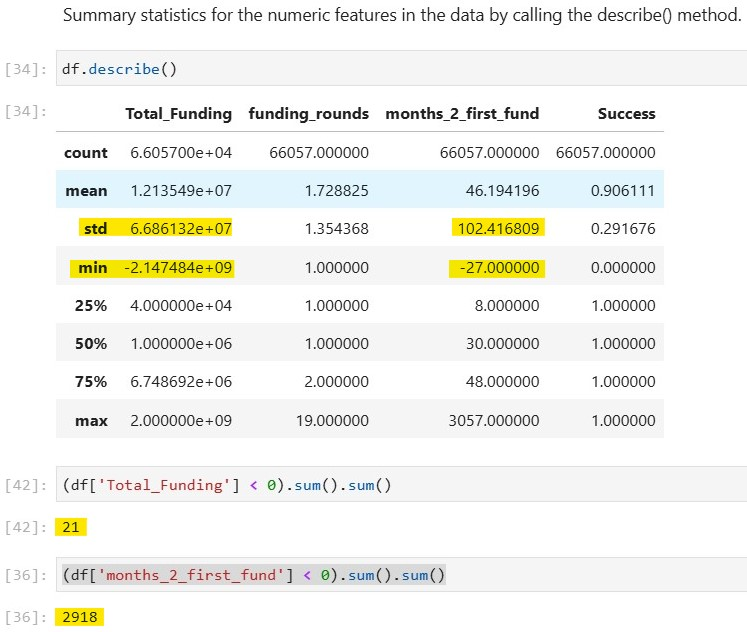
  
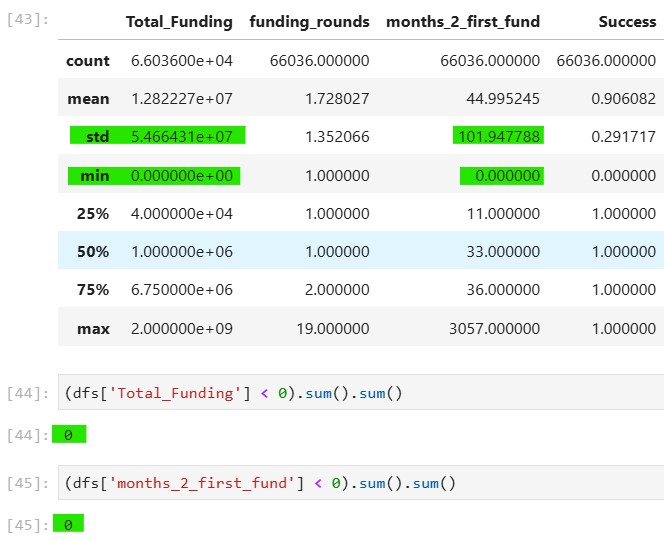
  
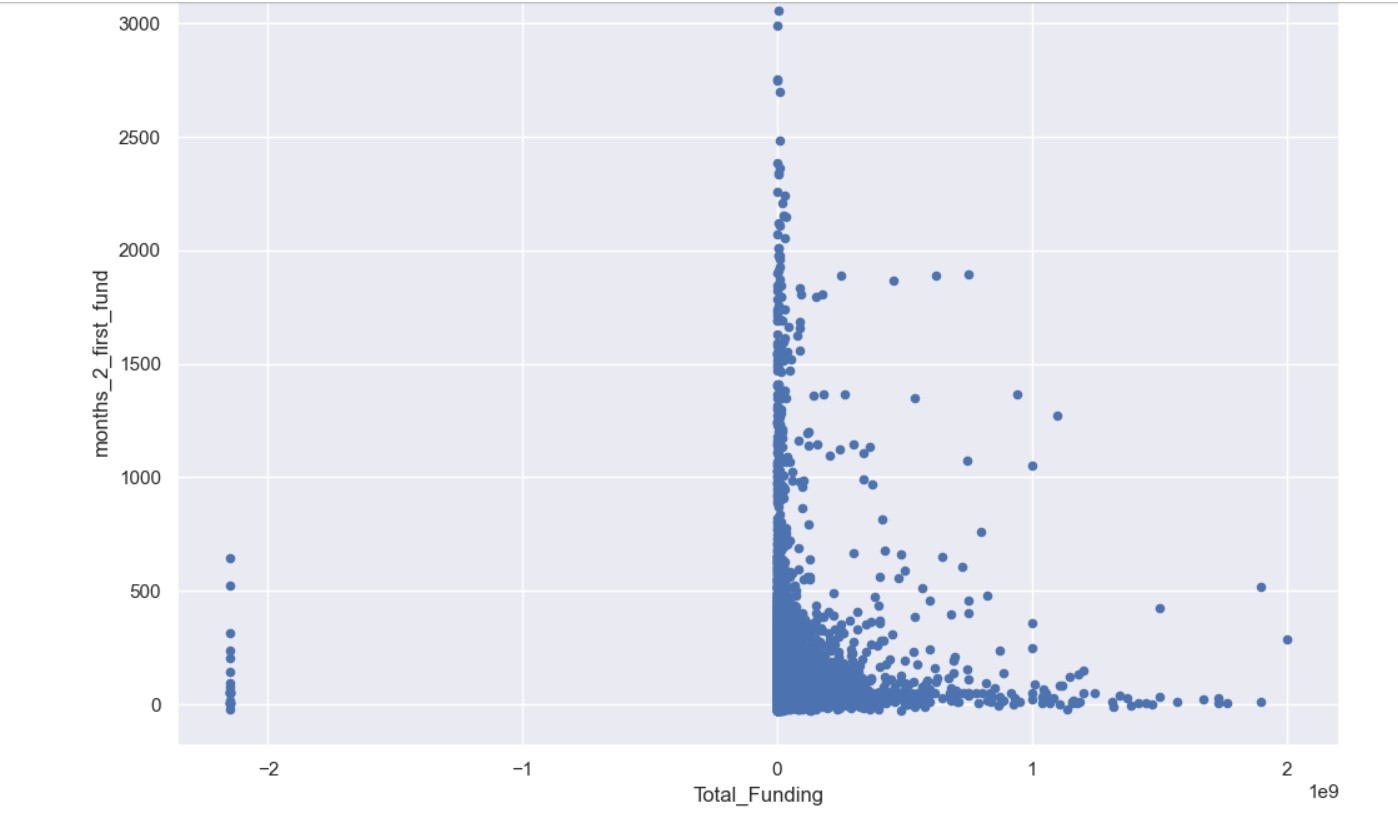

<AxesSubplot:xlabel='Total_Funding', ylabel='months_2_first_fund'>

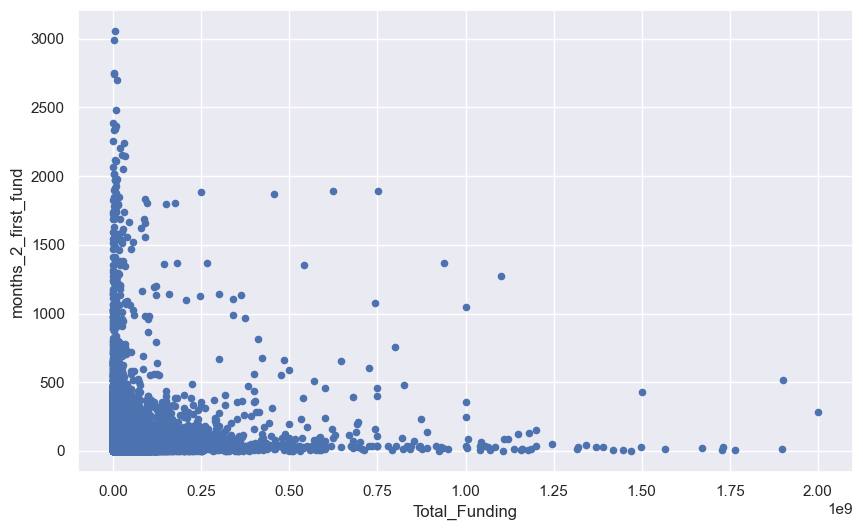

In [48]:
%matplotlib inline
dfs.plot(kind = 'scatter', x = 'Total_Funding', y = 'months_2_first_fund')

### 3.3. Pair plot for data overview

A useful way to have an overview of the data frame is by generating a pairplot (seaborn method pairplot) and pass in the entire data frame as a parameter. 

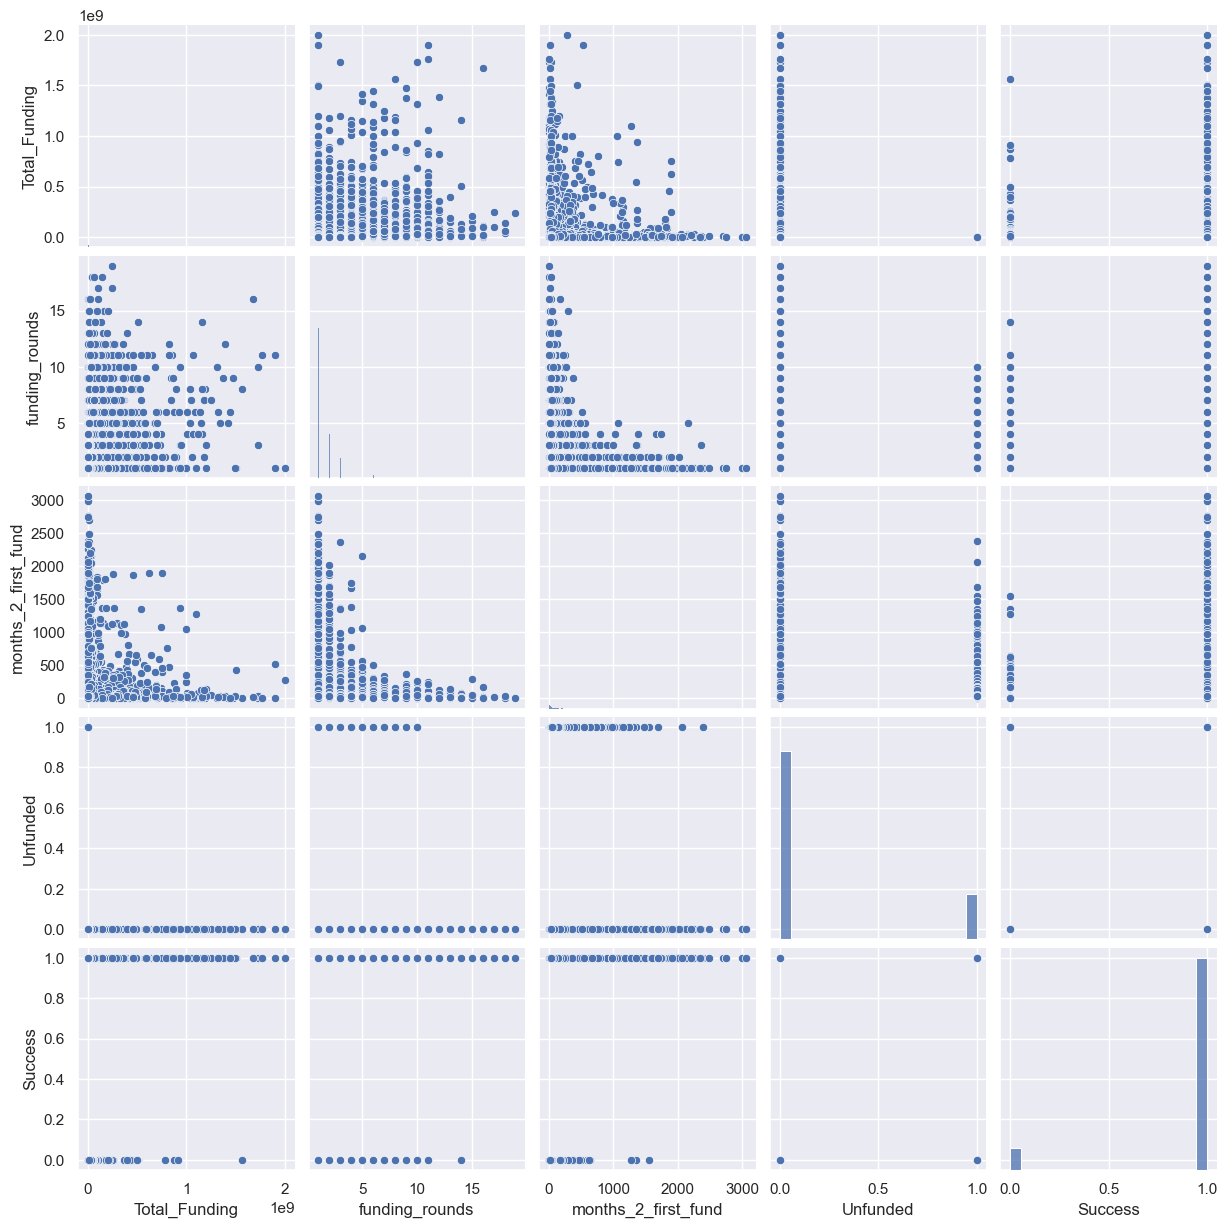

In [49]:
variables = dfs[['Total_Funding','funding_rounds','months_2_first_fund','Unfunded','Success']]
sns.pairplot(variables)

### 3.4. Use Pearson correlation test to confirm correlation

In [50]:
pc1 = pearsonr(dfs['Total_Funding'], dfs['Success'])
pc1

PearsonRResult(statistic=0.0250943178126551, pvalue=1.1222091666447952e-10)

Pearson correlation coefficient (r):0.02510. There is **no correlation between total funding and succcess**.  (Note: a value below -0.5 or above 0.5 indicates a notable correlation, and values below those values suggests a less notable correlation.)

The Two-tailed p-value:1.122 is greater than 0.05 indicating that there is a **NOT a statistically significant association** between the two variables 

In [51]:
pc2 = pearsonr(dfs['Total_Funding'], dfs['funding_rounds'])
pc2

PearsonRResult(statistic=0.30277156569776087, pvalue=0.0)

Pearson correlation coefficient (r):0.30278. There is a **weak positive correlation between total funding and funding_rounds**. (Note: a value below -0.5 or above 0.5 indicates a notable correlation, and values below those values suggests a less notable correlation.)

The Two-tailed p-value:0.0 is less than 0.05 indicating that there **is a statistically significant association** between the two variables

In [52]:
pc3 = pearsonr(dfs['Total_Funding'], dfs['months_2_first_fund'])
pc3

PearsonRResult(statistic=0.08909569248630954, pvalue=1.8315215417365756e-116)

Pearson correlation coefficient (r):0.0891. There is **no correlation between total funding and months_2_first_fund**.  (Note: a value below -0.5 or above 0.5 indicates a notable correlation, and values below those values suggests a less notable correlation.)

The Two-tailed p-value:1.8315 is greater than 0.05 indicating that there is a **NOT a statistically significant association** between the two variables 

In [53]:
pc4 = pearsonr(dfs['Success'], dfs['Unfunded'])
pc4

PearsonRResult(statistic=-0.016558808081365922, pvalue=2.0866998946085058e-05)

Pearson correlation coefficient (r):-0.01656. There is **no correlation between total success and funding**.  (Note: a value below -0.5 or above 0.5 indicates a notable correlation, and values below those values suggests a less notable correlation.)

The Two-tailed p-value:2.0867 is greater than 0.05 indicating that there is a **NOT a statistically significant association** between the two variables 

### 3.5. Normalise (or standardise) the data in the Total_Funding, funding_rounds and months_2_first_fund fields.

Use the scaler.fit_transform method from the sklearn.preprocessing subpackage to standerdise the `Total_Funding`, `funding_rounds` and `months_2_first_fund` fields.

In [54]:
dfst = scaler.fit_transform(dfs[['Total_Funding', 'funding_rounds', 'months_2_first_fund','Unfunded']])
print(dfst[0:5]) # print the first five elements in the array

[[-0.05162951 -0.53845953 -0.08823451 -0.48882445]
 [-0.22176009  0.20115511 -0.14708861 -0.48882445]
 [-0.17224152 -0.53845953 -0.08823451 -0.48882445]
 [-0.1979784  -0.53845953 -0.29422386 -0.48882445]
 [-0.23456562 -0.53845953  0.09813681  2.04572418]]


The scaler transformation returns a NumPy array that needs to be converted to a data frame (for convenience).

In [55]:
dfst = pd.DataFrame(dfst, columns = ['Total_Funding', 'funding_rounds', 'months_2_first_fund','Unfunded'])

In [56]:
dfst.head()

,Total_Funding,funding_rounds,months_2_first_fund,Unfunded
0,-0.051630,-0.538460,-0.088235,-0.488824
1,-0.221760,0.201155,-0.147089,-0.488824
2,-0.172242,-0.538460,-0.088235,-0.488824
3,-0.197978,-0.538460,-0.294224,-0.488824
4,-0.234566,-0.538460,0.098137,2.045724


In [57]:
dfm = pd.concat([dfst, dfs['Success']], axis=1, join="inner")
dfm.head()

,Total_Funding,funding_rounds,months_2_first_fund,Unfunded,Success
0,-0.051630,-0.538460,-0.088235,-0.488824,1
1,-0.221760,0.201155,-0.147089,-0.488824,1
2,-0.172242,-0.538460,-0.088235,-0.488824,1
3,-0.197978,-0.538460,-0.294224,-0.488824,1
4,-0.234566,-0.538460,0.098137,2.045724,1


## 4. Prepare the Data for the data model

#### Stage 1: separate the dependent variable
Separate the dependent variable 'y' from the independent variables. 

Create a pandas series `y` for the dependent variable.

In [58]:
y = dfm['Success'] #in variable 'y' save the column ['Success'] = response/dependent variable (categorial)
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Success, dtype: uint8

Then create a pandas DataFrame called X for the independent variables.

In [59]:
x = dfm[['Total_Funding', 'funding_rounds', 'months_2_first_fund','Unfunded']] 
# Notice the use of TWO sets of square brackets - because this is a dataframe, x is a dataframe and y is a series
x.head()

,Total_Funding,funding_rounds,months_2_first_fund,Unfunded
0,-0.051630,-0.538460,-0.088235,-0.488824
1,-0.221760,0.201155,-0.147089,-0.488824
2,-0.172242,-0.538460,-0.088235,-0.488824
3,-0.197978,-0.538460,-0.294224,-0.488824
4,-0.234566,-0.538460,0.098137,2.045724


#### Stage 2: split the data into training and test sets
The  objective of this step is to split the data into training and test sets. The training set will be used to train the model, while the test set will be used to evaluate the model.  

Next, import the `train_test_split()` function from the `sklearn.model_selection` subpackage. 

In [60]:
from sklearn.model_selection import train_test_split

#### Stage 3: Setting up the train and test data

Using the `train_test_split()` function, split `X` and `y` into `X_train`, `X_test`, `y_train` and `y_test`.

Note that within the `train_test_split()` function, set:

* `train_size` to `0.7`. This means we want $70\%$ of the original data to be assigned to the training data while $30\%$ is assigned to the test data. 

* Note that the default is 0.8 so that willl split the train at 80% and test at 20%

* Stratified random sampling is used because there are fewer *No* defaults in the categorical data `loan_status`. This ensures  that the sampling refects the distribution in the categories in the test and train data sets. 

* `stratify` as `y`. split the data using a stratified random sampling approach based on the values of `y`(which is the `loan_status`data. 

* `random_state` to `123`, ensures same results every time the data is split. 

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size = 0.7,stratify = y, random_state = 123)

After the data is split, the newly created `X_train` and `X_test` data sets hold the independent variables for the training and test sets, respectively. While the `y_train` and `y_test` data sets hold the dependent variable for the training and test sets respectively.

In [62]:
x_train.shape # Note that you do not use .shape() but just .shape

(46210, 4)

The result tells is that  46,225 out of the 66,057 instances in the startup data were assigned to the test set.

## 5. Training the Logistic Regression Model

Use the `LogisticRegression` class from the `sklearn.linear_model` subpackage to train the model.

In [63]:
from sklearn.linear_model import LogisticRegression

Create the model as a LogisticRegression object

In [64]:
model = LogisticRegression()

Train the model using the fit method on the model by passing in the x_train and y_train variables.  

Note: predict_proba(x)
Probability estimates. The returned estimates for all classes are ordered by the label of classes. Returns the log-probability of the sample for each class in the model.

In [65]:
model.fit(x_train, y_train).predict_proba(x_test)

array([[0.09233046, 0.90766954],
       [0.0931877 , 0.9068123 ],
       [0.09316478, 0.90683522],
       ...,
       [0.09338717, 0.90661283],
       [0.09206783, 0.90793217],
       [0.09308038, 0.90691962]])

The model is trained and is ready to make predictions.

## 6. Making Predictions With  Logistic Regression Model
Make a set of predictions with the test data using the logistic regression model and store the predictions in a variable called predictions.

In [66]:
predictions = model.predict(x_test)
predictions.shape

(19805,)

There are $19,805$ instances (or rows) in the test set. To predict labels for the test instances, we pass the independent variables of the test set (`X_test`) to the `predict()` method of the model.

## 7. Measuring the Performance of a Logistic Regression Machine Learning Model

*scikit-learn* has an excellent built-in module called classification_report that simplifies measuring the performance of a classification model.

In [67]:
from sklearn.metrics import classification_report

Use the classification report module to calculate the performance metrics for the logistic regression model

In [68]:
#classification_report(y_test, predictions)
#print(classification_report(y_test, predictions))

In [69]:
model.score(x_test, y_test)

0.9060843221408735


To evaluate how accurate our model is, pass the test data (X_test and y_test) to the score() method of the model.

The output 0.9061 shows that the model is able to correctly predict 9 out of ten (or 90%) of the labels in the test set

### 7.1. Confusion Matrix

The accuracy of a model only gives us a one-dimensional perspective of performance. To get a broader perspective, generate a confusion (or error) matrix of the model's performance. 
  
The confusion matrix clarifies the model output which can be evaluated against the test data. Next step is to interpret the model and use the model coefficients.
  
Import the `confusion_matrix` function from the `sklearn.metrics` subpackage.

In [70]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Pass the dependent variable from the test set (which are the actual labels) and the model's predicted labels to the `confusion_matrix()` function.

1) The first argument to the confusion matrix is y_test which are the actual labels.
2) The second argument to the confusion matrix is model.predict(x_test) which are the predicted labels 
3) The output is an array the array that we get is a 2 x 2 array that shows how many instances the model predicted correctly.
4) The confusion matrix is shown in the image below which shows for the first tuple (row 1) 3 true negatives 1 false positive.
5) For the seond tuple (row 2) 0 false negatives 5 true positives.

In [71]:
cm = confusion_matrix(y_test,predictions)
cm

array([[    0,  1860],
       [    0, 17945]], dtype=int64)

[Text(0, 0, '6201'), Text(0, 0, '59814')]

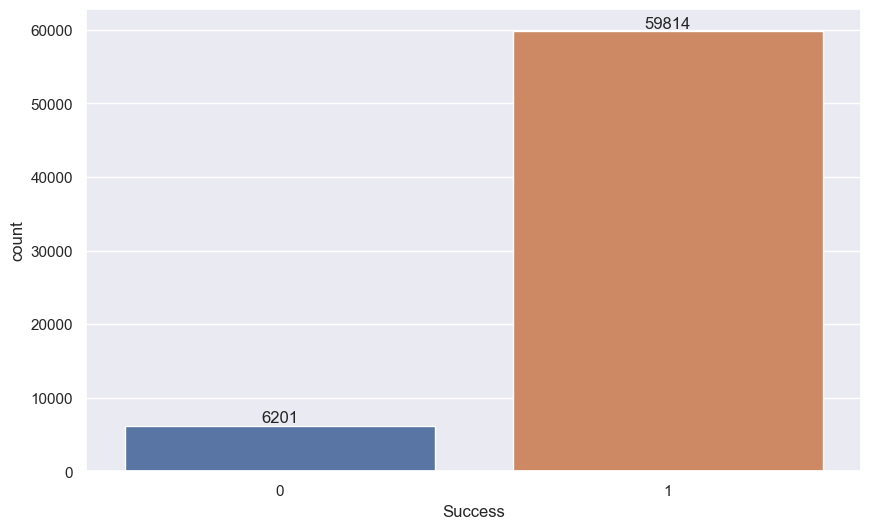

In [72]:
ax = sns.countplot(x ='Success', data = dfm);
defaults = dfm['Success'].value_counts(ascending=True).values
ax.bar_label(container=ax.containers[0], labels=defaults)

In [73]:
print('Class Ratio:',sum(dfm['Success'])/len(dfm['Success']))

Class Ratio: 0.9060668029993183


In [74]:
# check the distribution of the response variable (same as working out the ratio above)
dfm['Success'].value_counts()/dfm.shape[0]

1    0.906067
0    0.093933
Name: Success, dtype: float64

In [75]:
# performance
print(f'Accuracy Score: {accuracy_score(y_test,predictions)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, predictions)}')
print(f'Area Under Curve: {roc_auc_score(y_test, predictions)}')
print(f'Recall score: {recall_score(y_test,predictions)}')

Accuracy Score: 0.9060843221408735
Confusion Matrix: 
[[    0  1860]
 [    0 17945]]
Area Under Curve: 0.5
Recall score: 1.0


## 7.2.Imbalanced Success/failure ration in the response variable 
The `Success` response variable is imbalanced (90% sucess and 10% failure) but it is important to preserve that imbalance as it informs the model of the likelihood of a startup succeeding or failing.

Source: https://medium.com/towards-data-science/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68b

## 7.3 Weighted Logistic Regression
To specify weights we will make use of class_weight hyperparameter of Logistic-regression. The class_weight hyperparameter is a dictionary that defines weight of each label. Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have same weight value.

In [79]:
# define class weights
w = {0:10, 1:90}

Using the ratio in the response variable as the weighting in the regression algorithm then run the model again but this time as model_2

In [80]:
# define the model again this time using the weighted regression
model_2 = LogisticRegression(random_state=13, class_weight=w)
# fit model_2 again using the test/train set
model_2.fit(x_train,y_train)
# test the predictions 
predictions_2 = model_2.predict(x_test)

Review the performance of the model that is using a weighted response variable 

In [83]:
# performance
print(f'Accuracy Score: {accuracy_score(y_test,predictions_2)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, predictions_2)}')
print(f'Area Under Curve: {roc_auc_score(y_test, predictions_2)}')
print(f'Recall score: {recall_score(y_test,predictions_2)}')

Accuracy Score: 0.9060843221408735
Confusion Matrix: 
[[    0  1860]
 [    0 17945]]
Area Under Curve: 0.5
Recall score: 1.0


In [84]:
# define hyperparameters
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
crange = np.arange(0.5, 20.0, 0.5)
hyperparam_grid = {"class_weight": w
                   ,"penalty": ["l1", "l2"]
                   ,"C": crange
                   ,"fit_intercept": [True, False]  }

In [85]:
# logistic model classifier
lg4 = LogisticRegression(random_state=13)
# define evaluation procedure
grid = GridSearchCV(lg4,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
grid.fit(x,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
273000 fits failed out of a total of 546000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
273000 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only '

Best score: 0.49988188076394047 with param: {'C': 0.5, 'class_weight': {0: 0.001, 1: 1.0}, 'fit_intercept': True, 'penalty': 'l2'}
